In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    # lightrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]
    # summed_rain_each_period.loc[lightrainfall_times.index] = 1

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()

    return atg_obs_necessary

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
# atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2022,5,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2000-01-26 22:30:00,2000-01-26,14:54:00,43.8,1023.1,70.1,0.0
2000-01-26 23:00:00,2000-01-26,15:00:00,43.4,1023.2,72.1,0.0
2000-01-26 23:30:00,2000-01-26,15:30:00,45.3,1023.5,66.4,0.0
2000-01-27 00:00:00,2000-01-26,16:00:00,44.9,1023.5,66.6,0.0
2000-01-27 00:30:00,2000-01-26,16:30:00,44.8,1023.8,69.5,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [6]:
some_rains_from_all_time = atg_obs_necessary[atg_obs_necessary['rainfall_type']>=0.02]
some_rains_from_all_time

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2000-02-01 02:30:00,2000-01-31,18:30:00,46.3,1006.3,64.6,0.03
2000-02-01 03:00:00,2000-01-31,19:00:00,45.3,1005.9,67.9,0.03
2000-02-01 03:30:00,2000-01-31,19:30:00,43.9,1005.6,77.4,0.04
2000-02-01 04:00:00,2000-01-31,20:00:00,43.1,1004.7,84.5,0.03
2000-02-01 05:00:00,2000-01-31,21:00:00,43.5,1004.3,84.1,0.02
...,...,...,...,...,...,...
2024-05-22 01:00:00,2024-05-21,18:00:00,52.5,1009.5,92.4,0.03
2024-05-22 09:30:00,2024-05-22,02:30:00,47.5,1006.4,82.9,0.14
2024-05-22 10:00:00,2024-05-22,03:00:00,46.7,1007.0,92.9,0.07


In [7]:
no_rains_from_year_on = atg_obs_necessary[(atg_obs_necessary['rainfall_type']==0)&(atg_obs_necessary.index>=dt.datetime(2023,1,1))]
no_rains_from_year_on

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-01-01 00:00:00,2022-12-31,16:00:00,48.2,1008.5,80.8,0.0
2023-01-01 00:30:00,2022-12-31,16:30:00,48.2,1008.8,81.6,0.0
2023-01-01 01:00:00,2022-12-31,17:00:00,48.5,1009.2,81.2,0.0
2023-01-01 01:30:00,2022-12-31,17:30:00,47.4,1009.5,87.9,0.0
2023-01-01 02:00:00,2022-12-31,18:00:00,47.2,1009.8,89.0,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [16]:
relevant_events = pd.concat([some_rains_from_all_time, no_rains_from_year_on]).sort_index()
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2000-02-01 02:30:00,2000-01-31,18:30:00,46.3,1006.3,64.6,0.03
2000-02-01 03:00:00,2000-01-31,19:00:00,45.3,1005.9,67.9,0.03
2000-02-01 03:30:00,2000-01-31,19:30:00,43.9,1005.6,77.4,0.04
2000-02-01 04:00:00,2000-01-31,20:00:00,43.1,1004.7,84.5,0.03
2000-02-01 05:00:00,2000-01-31,21:00:00,43.5,1004.3,84.1,0.02
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.00
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.00
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.00


In [17]:
rainfall_times = relevant_events[(relevant_events['rainfall_type']>0.0)]
relevant_events.loc[rainfall_times.index, 'rainfall_type'] = 1
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2000-02-01 02:30:00,2000-01-31,18:30:00,46.3,1006.3,64.6,1.0
2000-02-01 03:00:00,2000-01-31,19:00:00,45.3,1005.9,67.9,1.0
2000-02-01 03:30:00,2000-01-31,19:30:00,43.9,1005.6,77.4,1.0
2000-02-01 04:00:00,2000-01-31,20:00:00,43.1,1004.7,84.5,1.0
2000-02-01 05:00:00,2000-01-31,21:00:00,43.5,1004.3,84.1,1.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [56]:
# def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
#     notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

#     relevant_events = pd.DataFrame()
#     for event_time in notable_event_times:
#         start_time = event_time-pd.Timedelta(days=num_days_around)
#         end_time = event_time+pd.Timedelta(days=num_days_around)
#         time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
#         relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
#     return relevant_events

In [11]:
# relevant_events = select_times_around_specific_events(atg_obs_necessary, 1, 30)
# relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2000-02-01 02:30:00,1,1,1.0,1.0,1.0,1.0
2000-02-01 03:00:00,1,1,1.0,1.0,1.0,1.0
2000-02-01 03:30:00,1,1,1.0,1.0,1.0,1.0
2000-02-01 04:00:00,1,1,1.0,1.0,1.0,1.0
2000-02-01 05:00:00,1,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


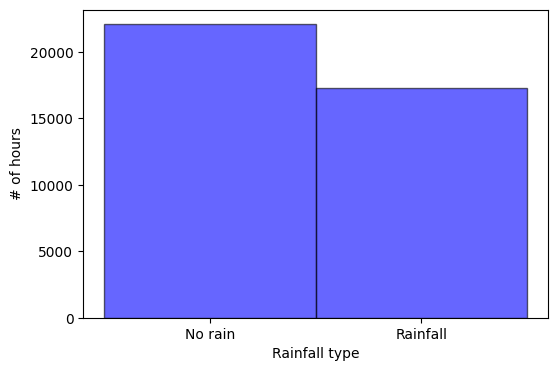

(array([22070, 17306]), array([0., 1., 2.]))

In [18]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [27]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [28]:
def create_balanced_df(processed_df):
    ones_samps = processed_df[processed_df['class']==1].copy()
    num_ones = ones_samps.shape[0]

    dupl_processed_df = ones_samps
    group = 0
    under_group_samps = processed_df[processed_df['class']==group].copy()
    group_samps = under_group_samps.sample(n=(num_ones), replace=False, random_state=42)

    dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [29]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

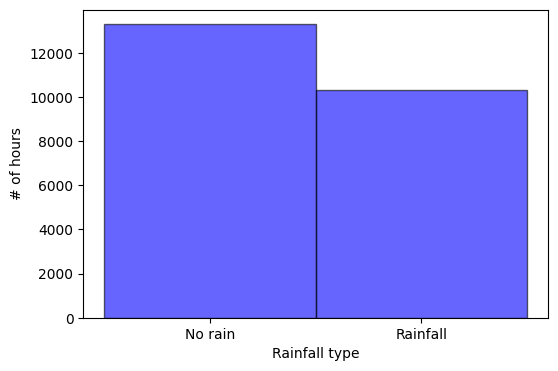

(array([13297, 10328]), array([0., 1., 2.]))

In [30]:
processed_df_train = get_processed_df_from_data(raw_under_df_train)
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [31]:
# processed_df_train = create_balanced_df(under_sam_reltimes_tr)
# processed_df_train

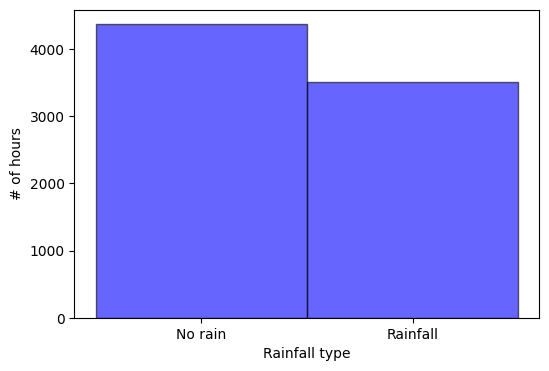

(array([4368, 3507]), array([0., 1., 2.]))

In [32]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_val['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_val['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_val['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [33]:
# processed_df_val = create_balanced_df(under_sam_reltimes_va)
processed_df_val

,months,feature_1,feature_2,feature_3,class
0,1,46.9,75.3,993.8,0.0
1,10,53.4,90.5,1008.2,0.0
2,8,80.3,35.3,1010.2,0.0
3,8,73.5,59.5,1011.5,0.0
4,2,44.3,90.6,1016.9,0.0
...,...,...,...,...,...
7870,8,69.3,62.0,1009.2,0.0
7871,1,19.2,46.7,1019.1,0.0
7872,3,51.7,88.7,1022.2,1.0
7873,6,75.8,49.6,1014.2,0.0


In [34]:
processed_df_train.shape, processed_df_val.shape

((23625, 5), (7875, 5))

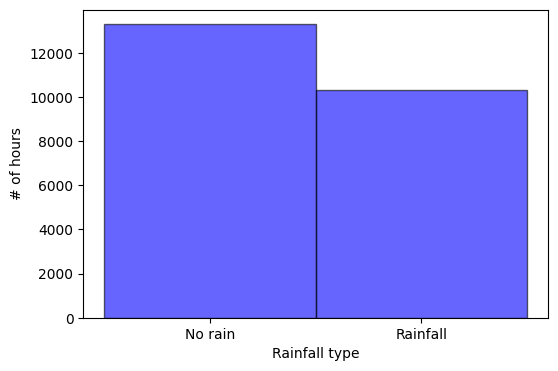

(array([13297, 10328]), array([0., 1., 2.]))

In [35]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

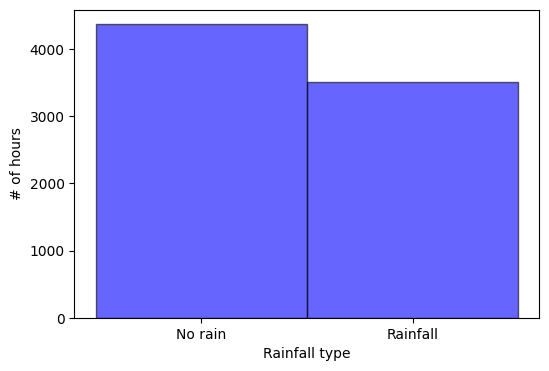

(array([4368, 3507]), array([0., 1., 2.]))

In [36]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [37]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(23625, 5)

In [38]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(7875, 5)

In [39]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, int(y_train_labs.max()+1))
print(x_data_train[0], y_data_train[0])

[  10.    56.7   87.6 1004.9] [0. 1.]


In [40]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, int(y_val_labs.max()+1))
print(x_data_val[0], y_data_val[0])

[  1.   46.9  75.3 993.8] [1. 0.]


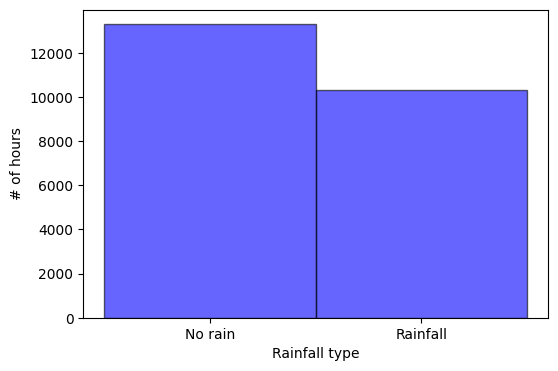

(array([13297, 10328]), array([0., 1., 2.]))

In [41]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

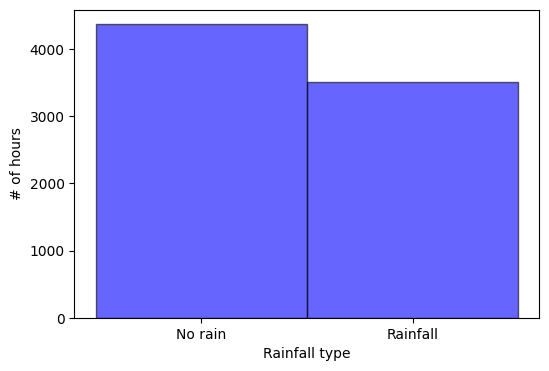

(array([4368, 3507]), array([0., 1., 2.]))

In [42]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(int(y_train_labs.max()+1), activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-06-02 14:28:33.702354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 14:28:33.703250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 128)               640       
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 25,558
Trainable params: 25,558
Non-traina

In [44]:
X_train_scaled.shape, y_data_train.shape

((23625, 4), (23625, 2))

In [45]:
X_val_scaled.shape, y_data_val.shape

((7875, 4), (7875, 2))

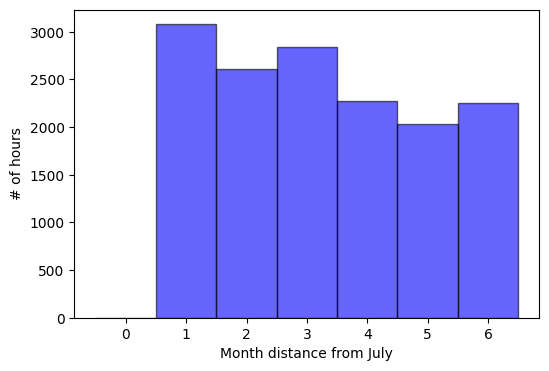

(array([   0, 3078, 2605, 2837, 2277, 2033, 2249]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [46]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [47]:
X_train_scaled

array([[ 1.08463106,  0.54006622,  0.76959447, -0.58836307],
       [ 0.29041232,  0.61645031,  0.06146729,  0.34915639],
       [ 0.81989148,  1.44712728, -1.93532376,  0.31262966],
       ...,
       [-1.29802517, -0.48157096,  0.90356447, -0.86840135],
       [-0.23906685, -0.30970676,  0.63562446, -0.67359211],
       [ 0.29041232,  0.76921849,  0.10612396,  1.01881316]])

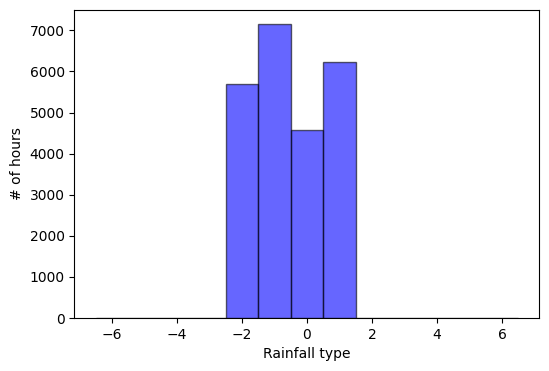

(array([   0,    0,    0,    0, 5683, 7147, 4568, 6227,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [48]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [49]:
scaler.mean_, scaler.scale_

(array([   5.90302646,   51.04367831,   75.53649101, 1009.73232169]),
 array([ 3.77729689, 10.4733854 , 15.67515038,  8.2131628 ]))

In [50]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-06-02 14:28:43.205296: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-02 14:28:43.526609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


739/739 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7773

2024-06-02 14:28:54.984656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


739/739 [==============================] - 14s 18ms/step - loss: 0.5332 - accuracy: 0.7773 - val_loss: 0.4769 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 2/100
739/739 [==============================] - 12s 17ms/step - loss: 0.4659 - accuracy: 0.7885 - val_loss: 0.4637 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/100
739/739 [==============================] - 12s 17ms/step - loss: 0.4573 - accuracy: 0.7907 - val_loss: 0.4556 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 4/100
739/739 [==============================] - 12s 16ms/step - loss: 0.4513 - accuracy: 0.7924 - val_loss: 0.4498 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 5/100
739/739 [==============================] - 12s 17ms/step - loss: 0.4494 - accuracy: 0.7908 - val_loss: 0.4472 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 6/100
739/739 [==============================] - 12s 17ms/step - loss: 0.4485 - accuracy: 0.7923 - val_loss: 0.4492 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 7/100
739/739 [==============================] - 12s 17ms/

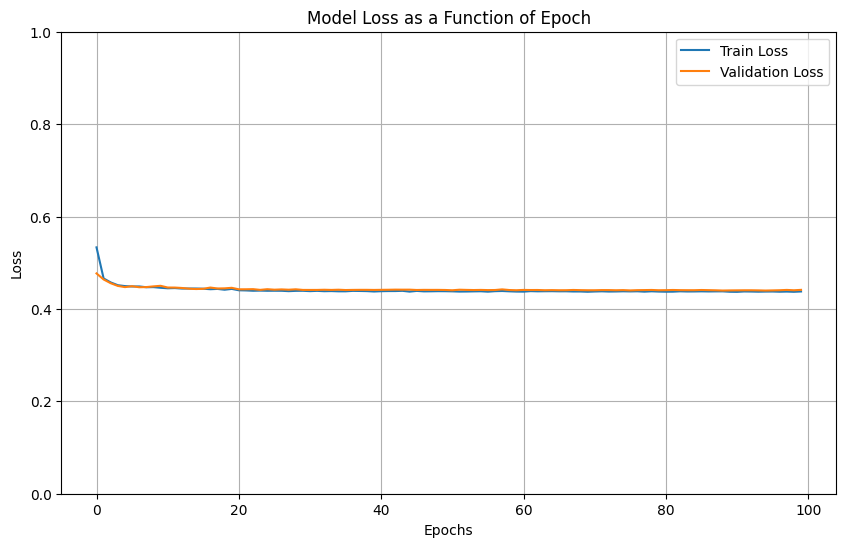

In [51]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

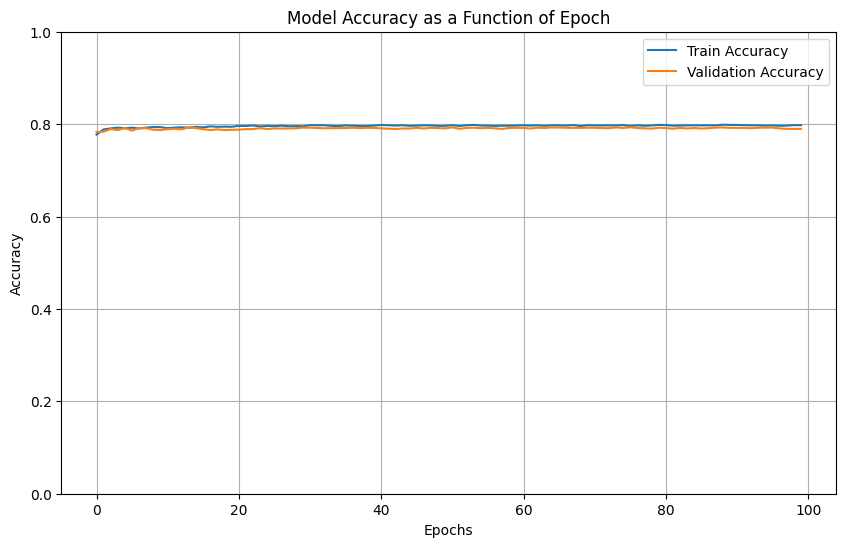

In [52]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

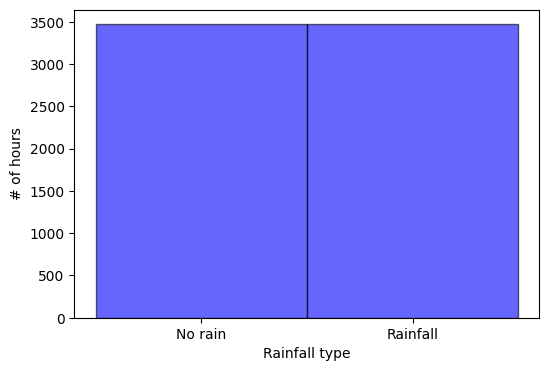

[3471 3471] [0. 1. 2.]
[  12.    51.7   78.1 1000.1] [0. 1.]


In [53]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_balanced_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, int(y_test_labs.max()+1))
print(x_data_test[0], y_data_test[0])

In [54]:
scaler.mean_, scaler.scale_

(array([   5.90302646,   51.04367831,   75.53649101, 1009.73232169]),
 array([ 3.77729689, 10.4733854 , 15.67515038,  8.2131628 ]))

In [55]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

 35/217 [===>..........................] - ETA: 0s

2024-06-02 14:52:41.167428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


217/217 [==============================] - 1s 3ms/step
217/217 - 2s - loss: 0.4506 - accuracy: 0.7903 - 2s/epoch - 9ms/step


[0.45063239336013794, 0.7902621626853943]

Confusion Matrix:
[[2712  759]
 [ 697 2774]]


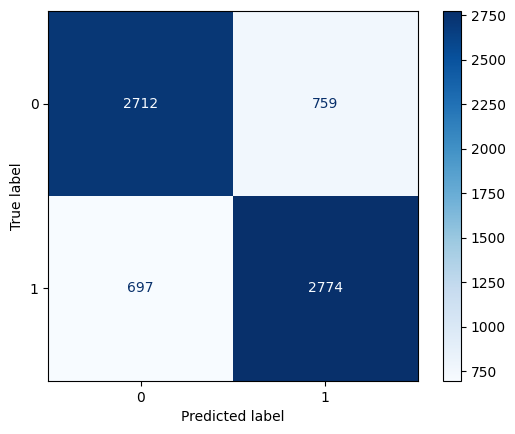

In [56]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[2712  759]
 [ 697 2774]]


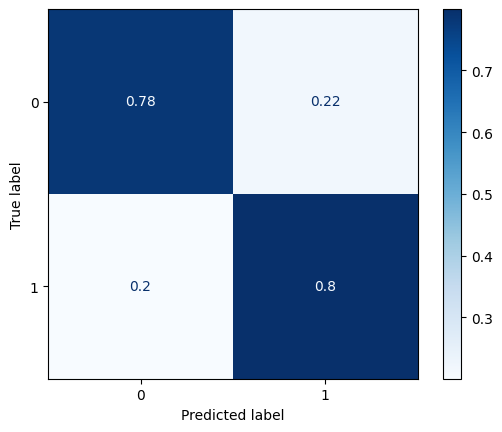

In [57]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [58]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.78837209, 0.79211879])

In [92]:
def create_oversampled_df_from_raw(processed_df):
    num_zeros = processed_df[processed_df['rainfall_type']==0].shape[0]

    zeros_samps = processed_df[processed_df['rainfall_type']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['rainfall_type']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['temperature'] = group_samps['temperature']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['pressure'] = group_samps['pressure']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['relhum'] = group_samps['relhum']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [93]:
raw_under_df_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-11 17:00:00,2023-05-11,10:00:00,63.3,1017.3,52.3,0.0
2024-02-29 06:00:00,2024-02-28,22:00:00,48.5,990.9,88.0,1.0
2022-08-03 03:30:00,2022-08-02,20:30:00,72.5,1011.1,52.5,0.0
2023-02-03 09:00:00,2023-02-03,01:00:00,45.2,1010.2,52.1,0.0
2022-12-19 23:00:00,2022-12-19,15:00:00,34.0,1021.0,85.0,0.0
...,...,...,...,...,...,...
2023-07-05 12:30:00,2023-07-05,05:30:00,64.2,1010.8,72.2,0.0
2023-06-05 18:00:00,2023-06-05,11:00:00,63.7,1017.5,47.2,0.0
2023-12-22 23:30:00,2023-12-22,15:30:00,45.0,1014.2,87.0,0.0


In [94]:
import calendar

18/18 [==============================] - 0s 5ms/step


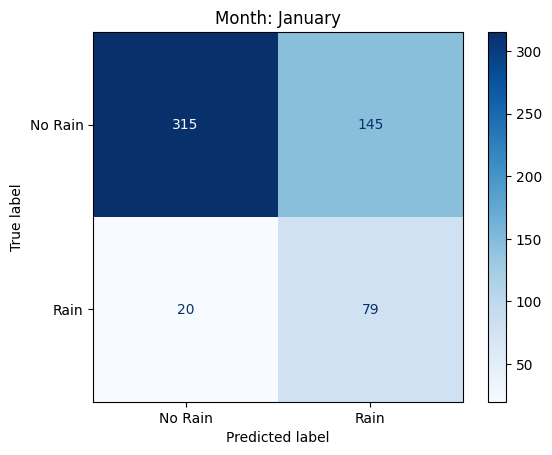

19/19 [==============================] - 0s 5ms/step


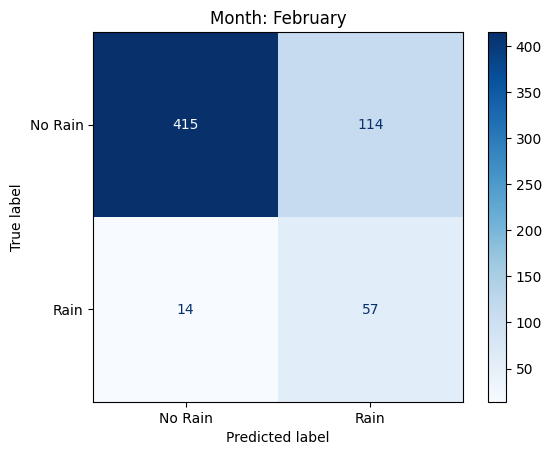

19/19 [==============================] - 0s 3ms/step


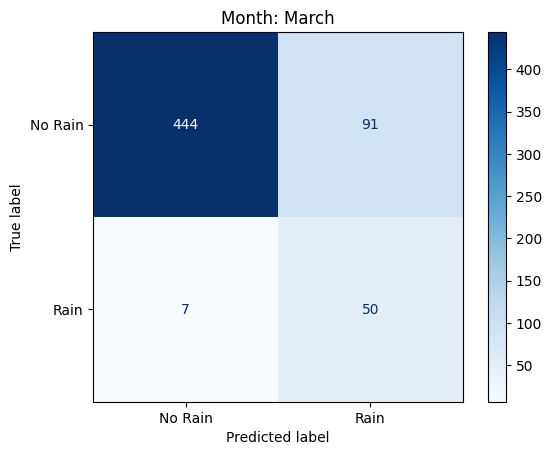

18/18 [==============================] - 0s 5ms/step


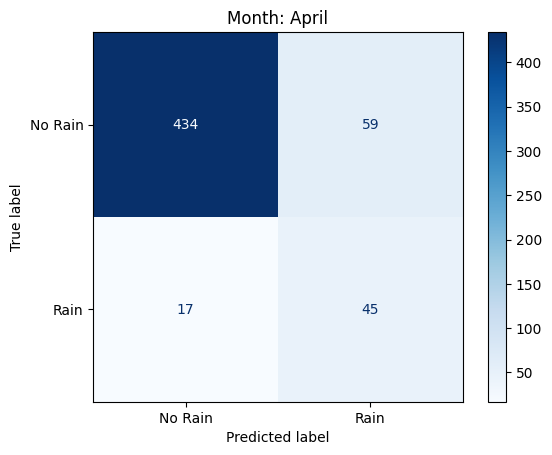

24/24 [==============================] - 0s 3ms/step


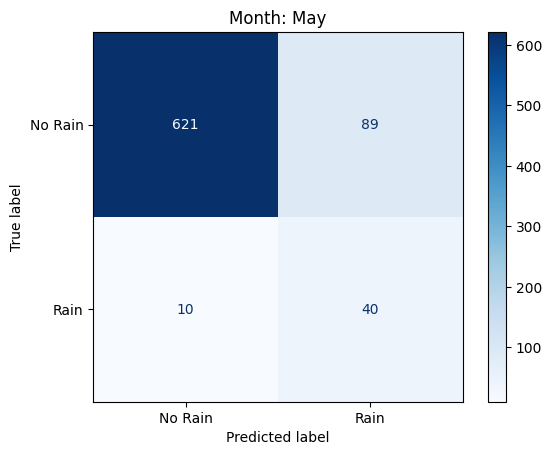

17/17 [==============================] - 0s 5ms/step


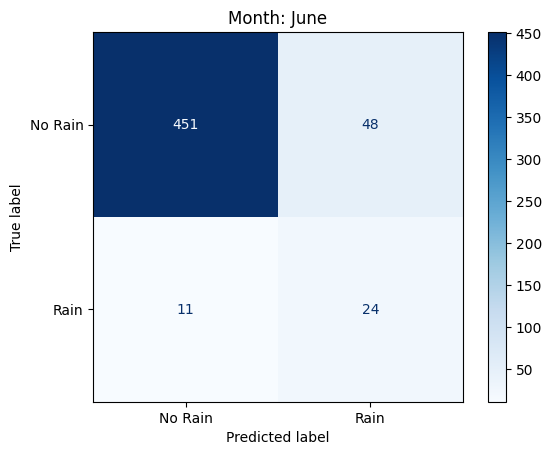

20/20 [==============================] - 0s 4ms/step


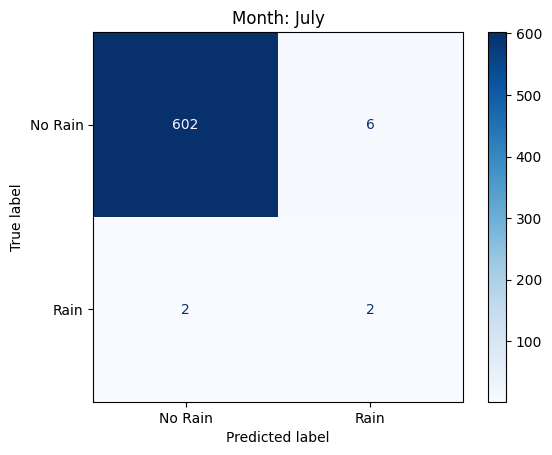

19/19 [==============================] - 0s 4ms/step


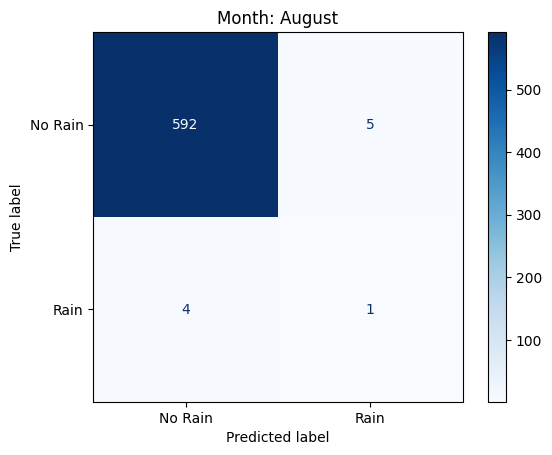

19/19 [==============================] - 0s 5ms/step


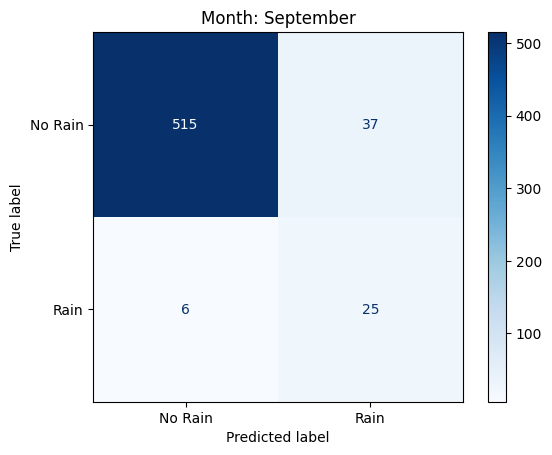

9/9 [==============================] - 0s 7ms/step


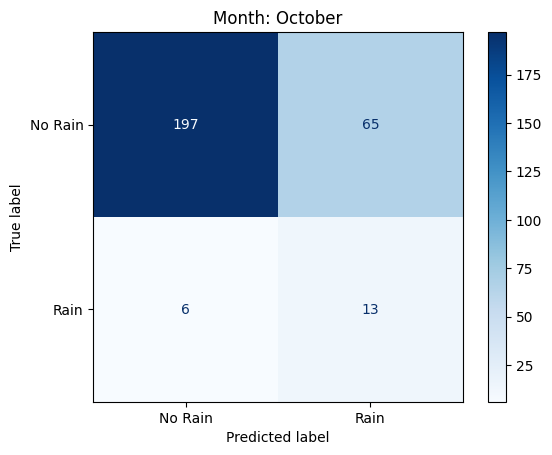

15/15 [==============================] - 0s 13ms/step


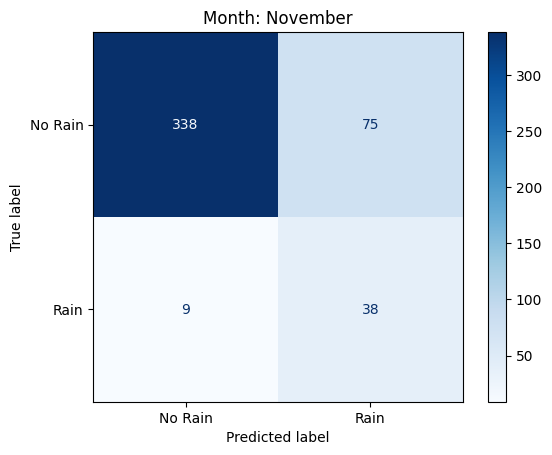

19/19 [==============================] - 0s 3ms/step


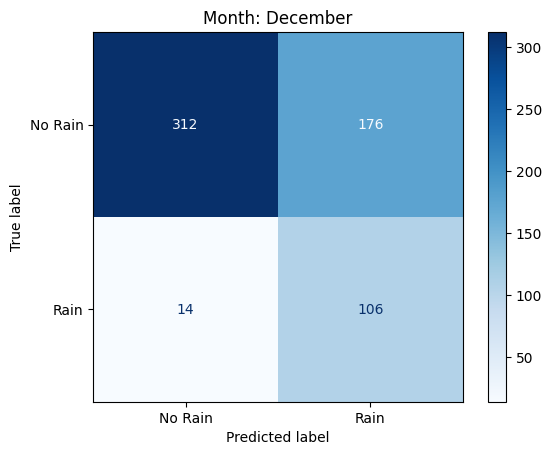

In [95]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(pd.DatetimeIndex(raw_under_df_test['date']).month==month_num), :].sort_index()
    # processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(test_data_sorted_month)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {calendar.month_name[month_num]}')
    plt.show()

In [397]:
# Assuming you have already trained your model
model.save('../models/2class_weather_for30.h5')

In [398]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("../models/2class_weather_for30.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("../models/2class_weather_for30.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmphqbz_sj4/assets


INFO:tensorflow:Assets written to: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmphqbz_sj4/assets


Model is 171108 bytes


2024-06-02 00:05:25.724059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-02 00:05:25.724080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-02 00:05:25.724256: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmphqbz_sj4
2024-06-02 00:05:25.726468: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-06-02 00:05:25.726480: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmphqbz_sj4
2024-06-02 00:05:25.734665: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-06-02 00:05:25.793968: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmphqbz_sj4
2024-06-

In [399]:
!echo "const unsigned char model[] = {" > ../arduino/2class_model_for30.h
!cat ../models/2class_weather_for30.tflite | xxd -i      >> ../arduino/2class_model_for30.h
!echo "};"                              >> ../arduino/2class_model_for30.h

In [400]:
import os
model_h_size = os.path.getsize("../arduino/2class_model_for30.h")
print(f"Header file, 2class_model_for30.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, 2class_model_for30.h, is 1,055,200 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
